In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
import pathlib
data_root_orig = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
data_root = pathlib.Path(data_root_orig)
print(data_root)

228818944/228813984 [==============================] - 442s 2us/step
C:\Users\qxm\.keras\datasets\flower_photos


In [4]:
for item in data_root.iterdir():
  print(item)

C:\Users\qxm\.keras\datasets\flower_photos\daisy
C:\Users\qxm\.keras\datasets\flower_photos\dandelion
C:\Users\qxm\.keras\datasets\flower_photos\LICENSE.txt
C:\Users\qxm\.keras\datasets\flower_photos\roses
C:\Users\qxm\.keras\datasets\flower_photos\sunflowers
C:\Users\qxm\.keras\datasets\flower_photos\tulips


In [5]:
import random
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

3670

In [6]:
all_image_paths[:10]

['C:\\Users\\qxm\\.keras\\datasets\\flower_photos\\daisy\\5684911529_88a7ae32ba_n.jpg',
 'C:\\Users\\qxm\\.keras\\datasets\\flower_photos\\tulips\\15976769174_1d50f46ca1_m.jpg',
 'C:\\Users\\qxm\\.keras\\datasets\\flower_photos\\dandelion\\3465599902_14729e2b1b_n.jpg',
 'C:\\Users\\qxm\\.keras\\datasets\\flower_photos\\roses\\6653567281_768a1fd160.jpg',
 'C:\\Users\\qxm\\.keras\\datasets\\flower_photos\\tulips\\5632006303_15acd2cf1e_n.jpg',
 'C:\\Users\\qxm\\.keras\\datasets\\flower_photos\\roses\\8437935944_aab997560a_n.jpg',
 'C:\\Users\\qxm\\.keras\\datasets\\flower_photos\\roses\\15498482197_8878cdfb07_n.jpg',
 'C:\\Users\\qxm\\.keras\\datasets\\flower_photos\\tulips\\574373182_2776669a79_n.jpg',
 'C:\\Users\\qxm\\.keras\\datasets\\flower_photos\\roses\\7187035716_5d0fb95c31_n.jpg',
 'C:\\Users\\qxm\\.keras\\datasets\\flower_photos\\roses\\4325834819_ab56661dcc_m.jpg']

In [7]:
import os
attributions = (data_root/"LICENSE.txt").open(encoding='utf-8').readlines()[4:]
attributions = [line.split(' CC-BY') for line in attributions]
attributions = dict(attributions)

In [8]:
import IPython.display as display

def caption_image(image_path):
    image_rel = pathlib.Path(image_path).relative_to(data_root)
    return "Image (CC BY 2.0) " + ' - '.join(attributions[str(image_rel)].split(' - ')[:-1])

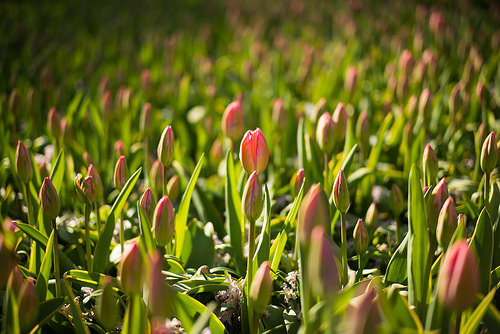

KeyError: 'tulips\\17189456156_6fc1067831.jpg'

In [9]:
for n in range(3):
  image_path = random.choice(all_image_paths)
  display.display(display.Image(image_path))
  print(caption_image(image_path))
  print()

In [12]:
label_to_index = dict((name, index) for index, name in enumerate(label_names))
label_to_index

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [13]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [14]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [0, 4, 1, 2, 4, 2, 2, 4, 2, 2]


In [15]:
img_path = all_image_paths[0]
img_path

'C:\\Users\\qxm\\.keras\\datasets\\flower_photos\\daisy\\5684911529_88a7ae32ba_n.jpg'

In [16]:
img_raw = tf.io.read_file(img_path)
print(repr(img_raw)[:100]+"...")

<tf.Tensor: id=1, shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x...


In [17]:
img_tensor = tf.image.decode_image(img_raw)

print(img_tensor.shape)
print(img_tensor.dtype)

(213, 320, 3)
<dtype: 'uint8'>


In [18]:
img_final = tf.image.resize(img_tensor, [192, 192])
img_final = img_final/255.0
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())

(192, 192, 3)
0.0
1.0


In [19]:
def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [192, 192])
  image /= 255.0  # normalize to [0,1] range

  return image

In [20]:
def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  return preprocess_image(image)

In [21]:
import matplotlib.pyplot as plt

image_path = all_image_paths[0]
label = all_image_labels[0]

plt.imshow(load_and_preprocess_image(img_path))
plt.grid(False)
plt.xlabel(caption_image(img_path))
plt.title(label_names[label].title())
print()

KeyError: 'daisy\\5684911529_88a7ae32ba_n.jpg'

In [22]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)

In [23]:
print(path_ds)

<TensorSliceDataset shapes: (), types: tf.string>


In [24]:
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

KeyError: 'daisy\\5684911529_88a7ae32ba_n.jpg'

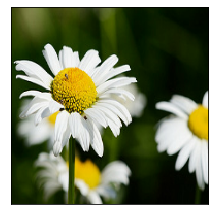

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
for n, image in enumerate(image_ds.take(4)):
  plt.subplot(2,2,n+1)
  plt.imshow(image)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(caption_image(all_image_paths[n]))
  plt.show()

In [26]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))

In [27]:
for label in label_ds.take(10):
  print(label_names[label.numpy()])

daisy
tulips
dandelion
roses
tulips
roses
roses
tulips
roses
roses


In [28]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

In [29]:
print(image_label_ds)

<ZipDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int64)>


In [30]:
ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))

# 元组被解压缩到映射函数的位置参数中
def load_and_preprocess_from_path_label(path, label):
  return load_and_preprocess_image(path), label

image_label_ds = ds.map(load_and_preprocess_from_path_label)
image_label_ds

<MapDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int32)>

In [31]:
BATCH_SIZE = 32

# 设置一个和数据集大小一致的 shuffle buffer size（随机缓冲区大小）以保证数据
# 被充分打乱。
ds = image_label_ds.shuffle(buffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
# 当模型在训练的时候，`prefetch` 使数据集在后台取得 batch。
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>

In [32]:
ds = image_label_ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.


<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>

In [33]:
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(192, 192, 3), include_top=False)
mobile_net.trainable=False

Exception: URL fetch failure on https://github.com/JonathanCMitchell/mobilenet_v2_keras/releases/download/v1.1/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_192_no_top.h5: None -- [Errno 11001] getaddrinfo failed

In [34]:
help(keras_applications.mobilenet_v2.preprocess_input)

NameError: name 'keras_applications' is not defined

In [35]:
model = tf.keras.Sequential([
  mobile_net,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(len(label_names), activation = 'softmax')])

NameError: name 'mobile_net' is not defined